# Import libraries

In [987]:
import reservoirpy as rpy
from collections import defaultdict
import seaborn as sns
from reservoirpy.nodes import Ridge, Reservoir, Input
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge as Ridge_sklearn
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import os
from chaos_indic import HurstTraj, NoiseFactor, DimEmb, max_lyapunov, fourier_harmonic_count, ks_entropy_partition
import tqdm
import skccm as ccm
from skccm.utilities import train_test_split
import warnings


rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(23)  # make everything reproducible!

# Data preprocessing and EDA

## Index Domclick

In [310]:
data_mredc_date = pd.read_csv(os.getcwd()+'/data/data_mredc_date.csv', index_col=0)
data_mredc_date['date'] = pd.to_datetime(data_mredc_date['date'], yearfirst=True)
data_mredc_date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    418 non-null    datetime64[ns]
 1   close   418 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.8 KB


## USD/RUB currency

In [311]:
usd_rub = pd.read_excel(os.getcwd()+'/data/usd_rub.xlsx')
usd_rub.info()
usd_rub.drop(columns=['nominal', 'cdx'], inplace=True)
usd_rub.rename(columns={'data':'date'}, inplace=True)
usd_rub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   nominal  2007 non-null   int64         
 1   data     2007 non-null   datetime64[ns]
 2   curs     2007 non-null   float64       
 3   cdx      2007 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 62.8+ KB


/Users/roman14/Downloads/Reservoir-Computing-Investigation/.venv/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,date,curs
0,2025-02-20,90.4268
1,2025-02-19,91.3398
2,2025-02-18,91.4347
3,2025-02-15,90.3099
4,2025-02-14,91.0313


## Inflation rate

In [312]:
infl = pd.read_excel(os.getcwd()+'/data/infl_msc.xls', decimal='.', skiprows=5, header=None)
infl = infl.iloc[:, 2:].T.rename(columns={0: 'infl'})
new_row = pd.DataFrame({'infl': [100.57]}) # инфляция по г.Москва, Январь 2025 г. к декабрю 2024 г.
infl = pd.concat([infl, new_row], ignore_index=True)
date_infl = pd.date_range('31-01-2017', periods=infl.shape[0], freq='ME')
infl['date'] = date_infl

# инфляция по г.Москва, декабрь 2016 (https://mosreg.ru/sobytiya/novosti/news-submoscow/inflyaciya-v-podmoskove-v-dekabre-proshlogo-goda-sostavila-0-4?utm_referrer=https%3A%2F%2Fwww.google.com%2F)
new_row = pd.DataFrame({'infl': [100.4], 'date': ['2016-12-31']})
new_row['date'] = pd.to_datetime(new_row['date'])
# Объединяем новую строку и исходный DataFrame
infl = pd.concat([new_row, infl], ignore_index=True)
infl.head()

,infl,date
0,100.40,2016-12-31
1,100.77,2017-01-31
2,100.38,2017-02-28
3,100.25,2017-03-31
4,100.42,2017-04-30


In [313]:
infl['infl'] = np.nancumprod(infl['infl']*0.01) #np.exp((infl['infl']*0.01-1).cumsum()) + np.log(1)
infl.head()

,infl,date
0,1.004000,2016-12-31
1,1.011731,2017-01-31
2,1.015575,2017-02-28
3,1.018114,2017-03-31
4,1.022390,2017-04-30


In [314]:
# Устанавливаем дату в индекс
infl.set_index('date', inplace=True)

# Создаем полный еженедельный индекс (по средам)
full_weekly_index = pd.date_range(data_mredc_date['date'].iloc[0], infl.index.max(), freq='D')

# Переиндексируем данные инфляции
infl_reindexed = infl.reindex(full_weekly_index)

# Интерполируем с учетом времени (линейно между месячными точками)
infl_interpolated = infl_reindexed.interpolate(method='time')

# Сбрасываем индекс и переименовываем колонки
infl_weekly = infl_interpolated.reset_index().rename(columns={'index': 'date'})

infl_weekly.head()

,date,infl
0,2016-12-28,NaN
1,2016-12-29,NaN
2,2016-12-30,NaN
3,2016-12-31,1.004000
4,2017-01-01,1.004249


## ROISFIX

In [315]:
roisfix = pd.read_csv(os.getcwd()+'/data/ROISFIX.csv', sep=';',
                       header=1, encoding='cp1251', decimal=',')
roisfix.head()

,Дата ставки,1W,2W,1M,2M,3M,6M,1Y,2Y,Unnamed: 9
0,16-04-2025,21.30,21.31,21.34,21.34,21.31,21.26,20.40,18.19,NaN
1,15-04-2025,21.45,21.40,21.41,21.42,21.36,21.29,20.46,18.23,NaN
2,14-04-2025,21.42,21.41,21.42,21.44,21.39,21.36,20.54,18.23,NaN
3,11-04-2025,21.43,21.42,21.42,21.44,21.44,21.43,20.62,18.25,NaN
4,10-04-2025,21.42,21.41,21.42,21.44,21.51,21.59,20.78,18.15,NaN


In [316]:
roisfix.rename(columns={'Дата ставки': 'date', '1W': 'roisfix_1w', '1M': 'roisfix_1m'}, inplace=True)
roisfix['date'] = pd.to_datetime(roisfix['date'], dayfirst=True)
roisfix = roisfix[['date', 'roisfix_1w', 'roisfix_1m']]
roisfix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3458 entries, 0 to 3457
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        3458 non-null   datetime64[ns]
 1   roisfix_1w  3458 non-null   float64       
 2   roisfix_1m  3458 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 81.2 KB


## Merging in one Dataframe

In [317]:
data_mredc_date = data_mredc_date.merge(usd_rub, how='left', on=['date'])
data_mredc_date = data_mredc_date.merge(infl_weekly, how='left', on=['date'])
data_mredc_date = data_mredc_date.merge(roisfix, how='left', on=['date'])
data_mredc_date.head()

,date,close,curs,infl,roisfix_1w,roisfix_1m
0,2016-12-28,159646.69,60.8587,NaN,10.11,10.03
1,2017-01-04,158952.36,NaN,1.004998,NaN,NaN
2,2017-01-11,158470.18,59.9533,1.006743,10.10,10.05
3,2017-01-18,157778.75,59.4015,1.008489,10.06,10.03
4,2017-01-25,157832.09,59.2168,1.010235,10.07,10.05


In [318]:
data_mredc_date['curs'].fillna(method='ffill', inplace=True)
data_mredc_date['roisfix_1w'].fillna(method='ffill', inplace=True)
data_mredc_date['roisfix_1m'].fillna(method='ffill', inplace=True)
data_mredc_date['curs_MA'] = data_mredc_date['curs'].rolling(13).mean()
data_mredc_date['curs_loged'] = np.log(data_mredc_date['curs']).diff()
data_mredc_date['infl_loged'] = np.log(data_mredc_date['infl']).diff()

data_mredc_date['MA_close'] = data_mredc_date['close'].rolling(13).mean()
data_mredc_date['log_return_close'] = np.log(data_mredc_date['close'].rolling(13).mean()).diff()

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_90117/674555782.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_mredc_date['curs'].fillna(method='ffill', inplace=True)
/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_90117/674555782.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_mredc_date['curs'].fillna(method='ffill', inplace=True)
/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_90117/67

## Visualization

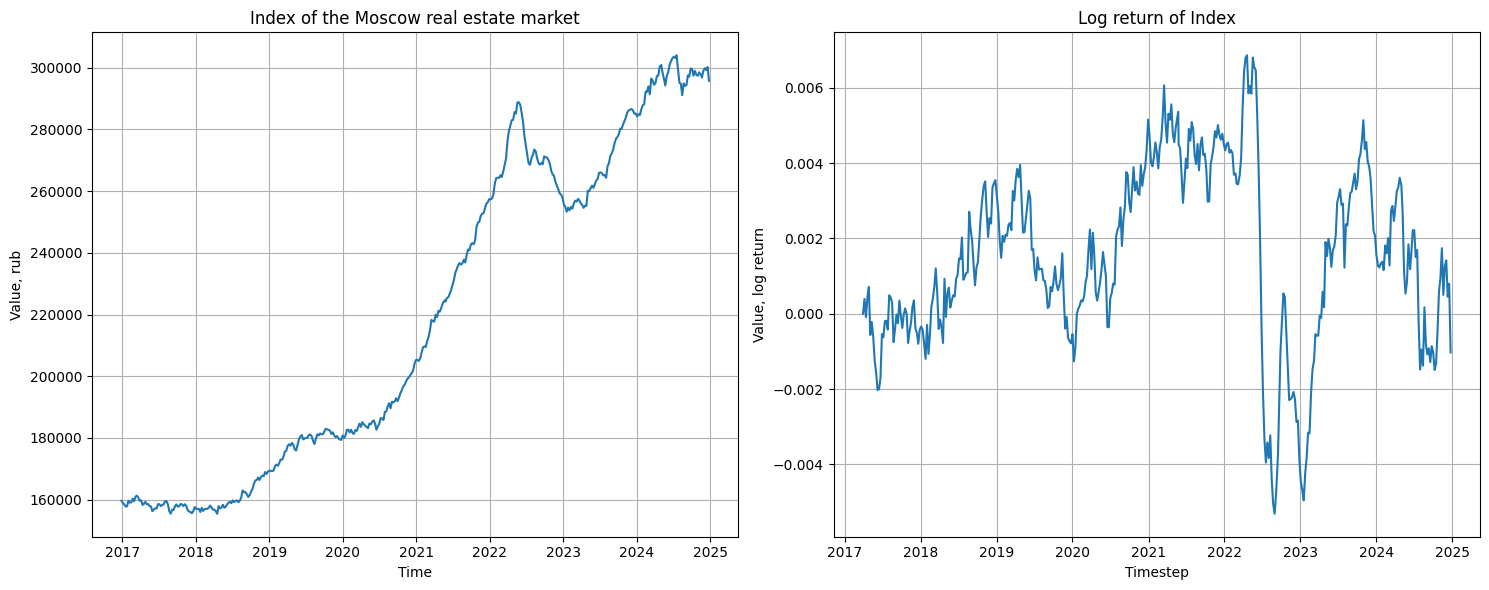

In [22]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(data_mredc_date['date'], data_mredc_date['close'])
plt.ylabel('Value, rub')
plt.xlabel('Time')
plt.title('Index of the Moscow real estate market')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(data_mredc_date['date'][13:], data_mredc_date['log_return_close'].dropna())
plt.ylabel('Value, log return')
plt.xlabel('Timestep')
plt.title('Log return of Index')
plt.grid()

plt.tight_layout()
plt.show()

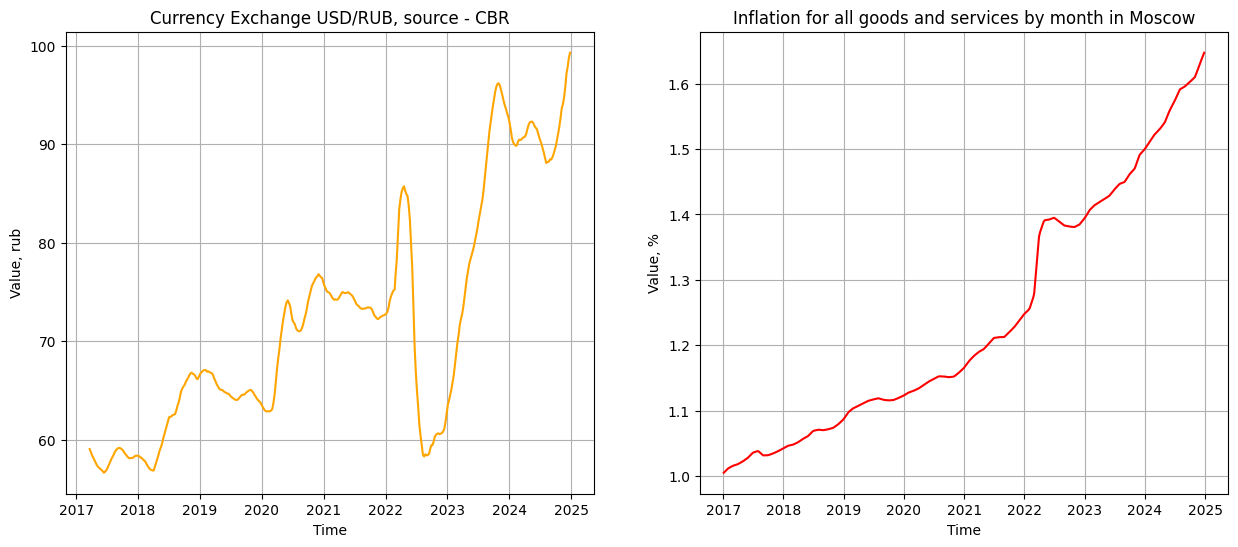

In [23]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(data_mredc_date['date'], data_mredc_date['curs'], color='orange')
plt.title('Currency Exchange USD/RUB, source - CBR')
plt.ylabel('Value, rub')
plt.xlabel('Time')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(data_mredc_date['date'], data_mredc_date['infl'], color='red')
plt.title('Inflation for all goods and services by month in Moscow')
plt.ylabel('Value, %')
plt.xlabel('Time')
plt.grid()

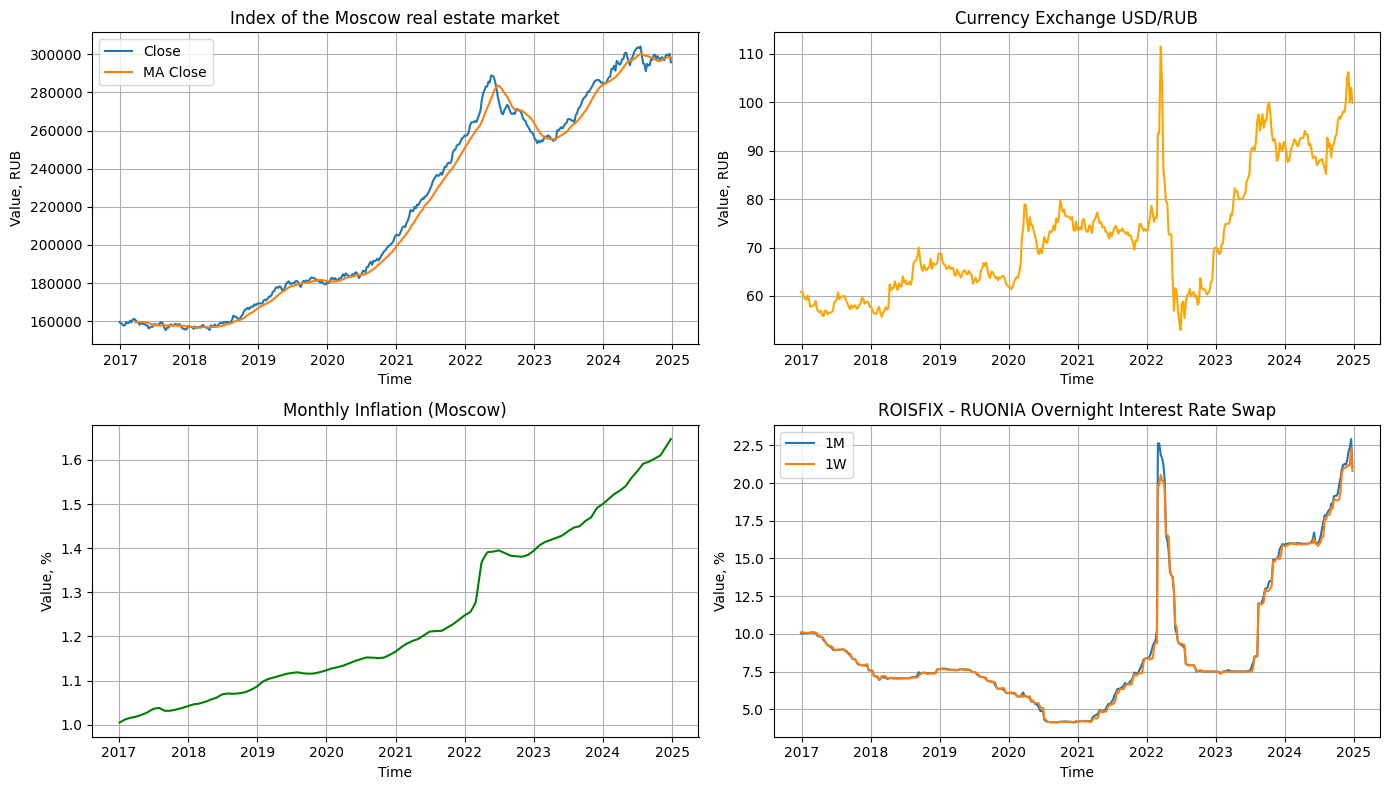

In [1047]:
plt.figure(figsize=(14, 8))

# 1
plt.subplot(2, 2, 1)
plt.plot(data_mredc_date['date'], data_mredc_date['close'], label='Close')
plt.plot(data_mredc_date['date'], data_mredc_date['MA_close'], label='MA Close')
plt.title('Index of the Moscow real estate market')
plt.ylabel('Value, RUB')
plt.xlabel('Time')
plt.legend()
plt.grid()

# 2
plt.subplot(2, 2, 2)
plt.plot(data_mredc_date['date'], data_mredc_date['curs'], color='orange')
plt.title('Currency Exchange USD/RUB')
plt.ylabel('Value, RUB')
plt.xlabel('Time')
plt.grid()

# 3
plt.subplot(2, 2, 3)
plt.plot(data_mredc_date['date'], data_mredc_date['infl'], color='green')
plt.title('Monthly Inflation (Moscow)')
plt.ylabel('Value, %')
plt.xlabel('Time')
plt.grid()

# 4
plt.subplot(2, 2, 4)
plt.plot(data_mredc_date['date'], data_mredc_date['roisfix_1m'], label='1M')
plt.plot(data_mredc_date['date'], data_mredc_date['roisfix_1w'], label='1W')
plt.title('ROISFIX - RUONIA Overnight Interest Rate Swap')
plt.ylabel('Value, %')
plt.xlabel('Time')
plt.legend()
plt.grid()

plt.tight_layout()


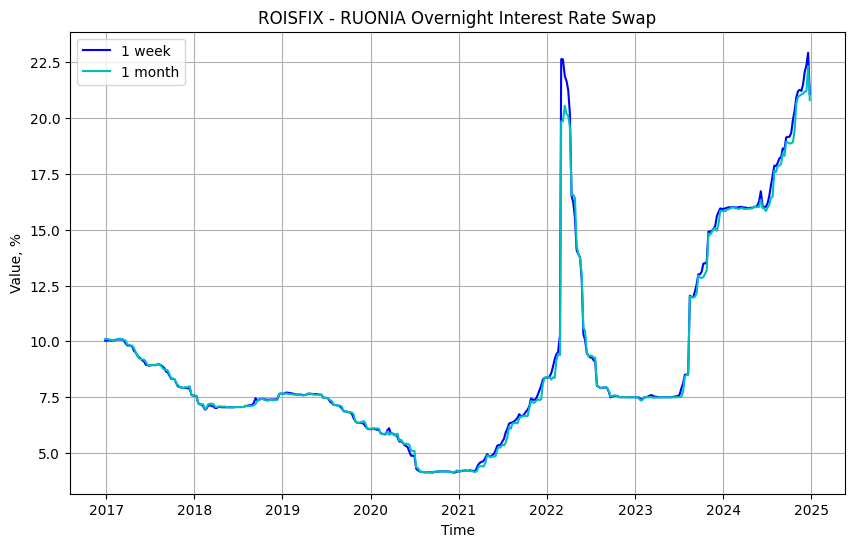

In [1040]:
plt.figure(figsize=(10,6))
plt.plot(data_mredc_date['date'], data_mredc_date['roisfix_1m'], label='1 week', color='blue')
plt.plot(data_mredc_date['date'], data_mredc_date['roisfix_1w'], label='1 month', color='c')
plt.title('ROISFIX - RUONIA Overnight Interest Rate Swap')
plt.ylabel('Value, %')
plt.xlabel('Time')
plt.legend()
plt.grid()

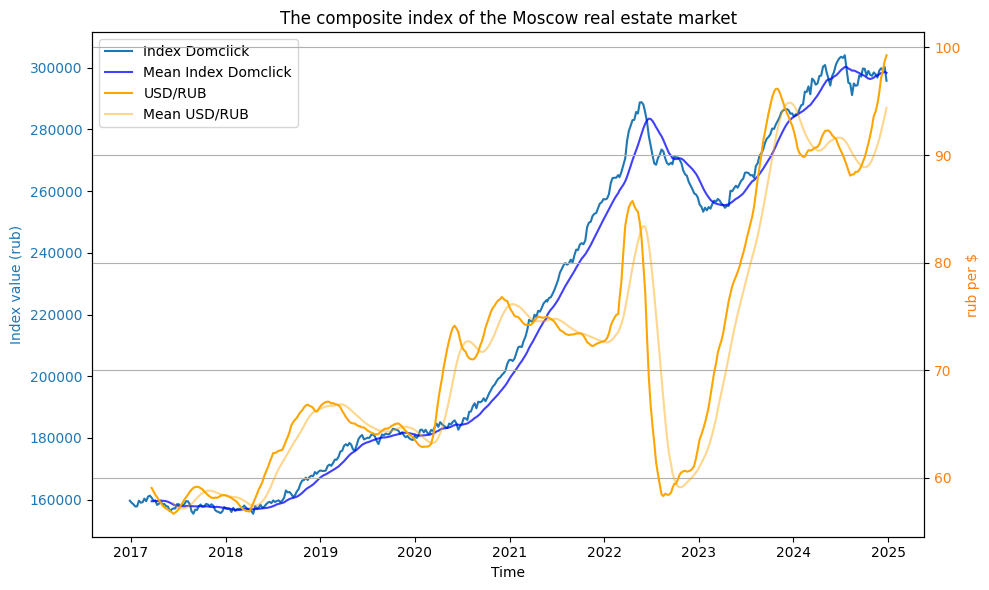

In [24]:
# Создаем фигуру и первую ось (ось Y для рублей)
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Index value (rub)', color=color1)
ax1.plot(data_mredc_date['date'], data_mredc_date['close'], color=color1, label='Index Domclick')
ax1.plot(data_mredc_date['date'], data_mredc_date['close'].rolling(13).mean(), color='blue', alpha=0.75, label='Mean Index Domclick')
ax1.tick_params(axis='y', labelcolor=color1)

# Создаем вторую ось Y, общую с осью X
ax2 = ax1.twinx()

color2 = 'tab:orange'
ax2.set_ylabel('rub per $', color=color2)
ax2.plot(data_mredc_date['date'], data_mredc_date['curs'], color='orange', label='USD/RUB')
ax2.plot(data_mredc_date['date'], data_mredc_date['curs'].rolling(13).mean(), color='orange', alpha=0.45, label='Mean USD/RUB')
ax2.tick_params(axis='y', labelcolor=color2)

# Добавляем заголовок и отображаем график
plt.title('The composite index of the Moscow real estate market')
fig.tight_layout()
plt.grid()

# Получаем линии и метки с обеих осей
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Объединяем и отображаем общую легенду
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

# Estimate chaotic measures

In [875]:
estimations = []

for series_name in data_mredc_date.columns[1:]:
    # Only process if enough data points
    if len(data_mredc_date[series_name]) < 1:
        continue
    
    # Compute metrics
    _, _, hurst_exponent, _ = HurstTraj(data_mredc_date[series_name].dropna())
    noise = NoiseFactor(data_mredc_date[series_name].dropna())
    _, corr_dim, _ = DimEmb(data_mredc_date[series_name].dropna())
    lyap_max = max_lyapunov(data_mredc_date[series_name].dropna().values)
    ks_ent = ks_entropy_partition(data_mredc_date[series_name].dropna())
    fourier_count = fourier_harmonic_count(data_mredc_date[series_name].dropna())
    
    estimations.append({
        'series': series_name,
        'hurst': hurst_exponent,
        'noise_factor': noise,
        'corr_dim': corr_dim,
        'lyap_max': lyap_max,
        'ks_entropy': ks_ent,
        'fourier_harmonics': fourier_count
    })

measures_df = pd.DataFrame(estimations)

In [1057]:
round(measures_df,2)

,series,hurst,noise_factor,corr_dim,lyap_max,ks_entropy,fourier_harmonics
0,close,0.74,0.98,2.89,0.03,3.59,31
1,curs,0.61,0.85,3.99,0.07,7.42,41
2,infl,0.81,0.99,1.23,0.01,1.60,34
3,roisfix_1w,0.78,0.86,0.90,0.06,4.77,36
4,roisfix_1m,0.67,0.84,0.94,0.11,4.76,38
5,curs_MA,0.79,0.96,2.23,0.02,4.47,31
6,curs_loged,0.45,-0.07,15.69,0.06,21.89,99
7,infl_loged,0.90,0.54,0.34,0.06,10.00,59
8,MA_close,0.65,0.99,1.33,0.01,1.84,30
9,log_return_close,0.75,0.83,4.20,0.07,11.36,39


# CCM

In [888]:
def CrossCorr(datax, datay, maxlag=52):
    """
    Find the lag (1…maxlag−1) that maximizes the absolute Spearman correlation
    between datax and datay shifted by that lag.
    Returns: (best_lag, best_correlation)
    """
    dx = pd.Series(datax)
    dy = pd.Series(datay)
    best_corr = 0.0
    best_lag  = 1
    for lag in range(1, maxlag):
        c = abs(dx.corr(dy.shift(lag), method='spearman'))
        if c > best_corr:
            best_corr = c
            best_lag  = lag
    return best_lag, best_corr

def ccm_test(x1, x2, maxlag=52):
    """
    Identify the optimal lag and embedding dimension for CCM between x1 (target)
    and x2 (predictor). Returns (lag, embed, max_corr).
    """
    warnings.filterwarnings("ignore")

    # 1) pick lag via Spearman Cross‐correlation
    lag, _ = CrossCorr(x1, x2, maxlag=maxlag)

    best_score = -np.inf
    best_embed = None

    # 2) sweep embedding dimension
    for E in range(2, 6):
        e1 = ccm.Embed(x1)
        e2 = ccm.Embed(x2)
        X1 = e1.embed_vectors_1d(lag, E)
        X2 = e2.embed_vectors_1d(lag, E)

        x1_tr, x1_te, x2_tr, x2_te = train_test_split(X1, X2, percent=0.9)
        lib_lens = np.unique(np.linspace(10, len(x1_tr), num=20, dtype=int))

        model = ccm.CCM(score_metric='corrcoef')
        model.fit(x1_tr, x2_tr)
        model.predict(x1_te, x2_te, lib_lengths=lib_lens)
        sc1, _ = model.score()  # sc1 is the array of corrcoefs for X1→X2

        if max(sc1) > best_score:
            best_score = max(sc1)
            best_embed = E

    return lag, best_embed, best_score

def choose_preds_ccm(df, target_col, top_n=5, maxlag=52):
    """
    Rank all columns in df (except target_col) by their CCM causality score
    with target_col, and return the top_n predictors.
    """
    # 1) drop any rows with NaNs in target or predictors
    preds = [c for c in df.columns if c != target_col]
    df_clean = df.dropna(subset=[target_col] + preds).reset_index(drop=True)

    # 2) scale target to [-1,1]
    y = df_clean[target_col].values
    y_scaled = y / np.max(np.abs(y))

    results = []
    for pred in preds:
        x = df_clean[pred].values
        # normalize predictor to [0,1]
        x_norm = (x - x.min())/(x.max() - x.min())

        lag, embed, score = ccm_test(y_scaled, x_norm, maxlag=maxlag)
        results.append({
            'predictor': pred,
            'lag':       lag,
            'embed':     embed,
            'score':     score
        })

    # 3) sort by descending CCM score and return top_n
    return sorted(results, key=lambda d: d['score'], reverse=True)[:top_n]

In [881]:
data_mredc_date.columns

Index(['date', 'close', 'curs', 'infl', 'roisfix_1w', 'roisfix_1m', 'curs_MA',
       'curs_loged', 'infl_loged', 'MA_close', 'log_return_close'],
      dtype='object')

In [1218]:
top_features = choose_preds_ccm(data_mredc_date.drop(columns=['date', 'close', 'log_return_close', 'curs_loged', 'infl_loged']).dropna(),
     target_col='MA_close', top_n=5)
top_features

[{'predictor': 'infl',
  'lag': 19,
  'embed': 2,
  'score': np.float64(0.7827107974595926)},
 {'predictor': 'curs_MA',
  'lag': 24,
  'embed': 3,
  'score': np.float64(0.7352777491685522)},
 {'predictor': 'curs',
  'lag': 31,
  'embed': 3,
  'score': np.float64(0.6861679024268735)},
 {'predictor': 'roisfix_1m',
  'lag': 1,
  'embed': 2,
  'score': np.float64(0.45589469856111464)},
 {'predictor': 'roisfix_1w',
  'lag': 1,
  'embed': 4,
  'score': np.float64(0.4109332280354005)}]

In [1195]:
choose_preds_ccm(data_mredc_date.drop(columns=['date', 'close', 'MA_close']).dropna(),
     target_col='log_return_close', top_n=5)

[{'predictor': 'infl',
  'lag': 1,
  'embed': 2,
  'score': np.float64(0.7159270889818017)},
 {'predictor': 'roisfix_1w',
  'lag': 36,
  'embed': 3,
  'score': np.float64(0.6633302639975892)},
 {'predictor': 'roisfix_1m',
  'lag': 37,
  'embed': 3,
  'score': np.float64(0.4675312189599606)},
 {'predictor': 'curs',
  'lag': 7,
  'embed': 4,
  'score': np.float64(0.4666395992123344)},
 {'predictor': 'infl_loged',
  'lag': 8,
  'embed': 3,
  'score': np.float64(0.43114142561894503)}]

In [897]:
X0 = data_mredc_date.copy()
X0 = X0.drop(columns=['date', 'close', 'log_return_close']).dropna()

In [ ]:
# embed_info = {d['predictor']:(d['lag'], d['embed']) for d in embed_info_list}

In [1109]:
dmd = data_mredc_date.copy()
dmd['infl_laged'] = dmd['infl'].shift(19)
dmd['curs_MA_laged'] = dmd['curs_MA'].shift(24)
dmd['curs_laged'] = dmd['curs'].shift(31)
dmd['roisfix_1m_laged'] = dmd['roisfix_1m'].shift(2)
dmd['roisfix_1w_laged'] = dmd['roisfix_1w'].shift(4)

# Define models

In [732]:
class EnhancedESN_FAN:
    def __init__(self,
                 input_dim,
                 reservoir_size=100,
                 spectral_radius=0.9,
                 sparsity=0.1,
                 ridge_alpha=1.0,
                 leaking_rate=1.0,
                 poly_order=2,
                 fan_dp=5,
                 seed=23):
        """
        input_dim : dimensionality of X (features per timestep)
        fan_dp    : number of Fourier terms (dp in the FAN paper)
        """
        np.random.seed(seed)
        self.reservoir_size = reservoir_size
        self.poly = PolynomialFeatures(degree=poly_order, include_bias=False)
        self.fan_dp = fan_dp

        # placeholders; actual Win/W init happens in fit()
        self.Win = None
        self.W   = None

        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.leaking_rate = leaking_rate

        self.ridge = Ridge_sklearn(alpha=ridge_alpha)
        self.scaler = StandardScaler()
        self.input_scaler = StandardScaler()

    def initialize_weights(self, X):
        # input‐distribution aware Win
        inp_mean, inp_std = X.mean(axis=0), X.std(axis=0)
        mu, sigma = inp_mean.mean(), inp_std.mean()
        self.Win = np.random.normal(mu, sigma, (self.reservoir_size, X.shape[1] + 1))

        # sparse W with spectral radius
        W = np.random.rand(self.reservoir_size, self.reservoir_size) - 0.5
        W[np.random.rand(*W.shape) > self.sparsity] = 0
        W *= self.spectral_radius / np.max(np.abs(np.linalg.eigvals(W)))
        self.W = W

    def _update(self, state, u):
        # standard ESN update
        # pre = self.Win @ np.concatenate(([1], u)) + self.W @ state
        # return np.tanh(pre)
        pre_activation = self.Win @ np.concatenate(([1], u)) + self.W @ state
        new_state = np.tanh(pre_activation)
        
        # Integrate leaking rate
        updated_state = (1 - self.leaking_rate) * state + self.leaking_rate * new_state
        return updated_state

    def _fourier_features(self, X):
        # X: (n_samples, n_features)
        # return: (n_samples, 2*fan_dp*n_features)
        # FAN: explicit Fourier series terms sin(2πk x), cos(2πk x)
        features = []
        for k in range(1, self.fan_dp + 1):
            features.append(np.sin(2 * np.pi * k * X))
            features.append(np.cos(2 * np.pi * k * X))
        return np.hstack(features)
    
    # def _fft_features(self, X, n_coeffs):
    #     # X: (T, n) time series
    #     # return first n_coeffs magnitudes per dimension
    #     coeffs = np.abs(fft(X, axis=0))[:n_coeffs]  # shape (n_coeffs, n)
    #     return np.tile(coeffs.flatten(), (X.shape[0], 1))

    def fit(self, X, y):
        """
        X: shape (T, input_dim)
        y: shape (T,) or (T, output_dim)
        """
        # init reservoir
        self.initialize_weights(X)

        # collect reservoir states
        T = X.shape[0]
        states = np.zeros((T, self.reservoir_size))
        state = np.zeros(self.reservoir_size)
        for t in range(T):
            state = self._update(state, X[t])
            states[t] = state

        X_scaled = self.input_scaler.fit_transform(X)
        # polynomial features
        P = self.poly.fit_transform(X_scaled)
        # Fourier analysis network features
        F = self._fourier_features(X_scaled)

        # # combine all
        # H = np.hstack([states, P, F])

        # # scale & fit readout
        # Hs = self.scaler.fit_transform(H)
        # self.ridge.fit(Hs, y)

        H = np.hstack([states, P, F])
        self.scaler.fit(H)
        # prevent division by zero in .transform()
        self.scaler.scale_[self.scaler.scale_ == 0.0] = 1.0
        Hs = self.scaler.transform(H)
        self.ridge.fit(Hs, y)


    def predict(self, X, generative_steps=None):
        """
        If X is (T, input_dim) and generative_steps is None, this is open-loop:
          returns readout(X)
        If generative_steps is an int > 0, we perform:
          - use X[-1] as u0, then recursively predict next u's.
        """
        if generative_steps is None:
            # one‐shot prediction (teacher forcing)
            T = X.shape[0]
            states = np.zeros((T, self.reservoir_size))
            state = np.zeros(self.reservoir_size)
            for t in range(T):
                state = self._update(state, X[t])
                states[t] = state

            P = self.poly.transform(X)
            F = self._fourier_features(X)
            H = np.hstack([states, P, F])
            Hs = self.scaler.transform(H)
            return self.ridge.predict(Hs)

        # generative forecasting
        u = X[-1].copy()      # last observed input
        state = np.zeros(self.reservoir_size)
        preds = []
        for _ in range(generative_steps):
            state = self._update(state, u.reshape(-1))
            # build feature row
            # P = self.poly.transform(u.reshape(1, -1))
            # F = self._fourier_features(u.reshape(1, -1))
            u_scaled = self.input_scaler.transform(u.reshape(1, -1))
            clip = 3.0  # you can tune this (e.g. 3 standard deviations)
            u_scaled = np.clip(u_scaled, -clip, clip)

            P = self.poly.transform(u_scaled)
            F = self._fourier_features(u_scaled)
            h = np.hstack([state, P.ravel(), F.ravel()]).reshape(1, -1)
            h_s = self.scaler.transform(h)
            u_next = self.ridge.predict(h_s)
            preds.append(u_next.ravel())
            u = u_next  # feed back

        return np.vstack(preds)

In [ ]:
units = 200
leak_rate = 0.9
spectral_radius = 1.1
input_scaling = 1.0
connectivity = 0.5
input_connectivity = 0.5
regularization = 1e-8
seed = 23

In [845]:
def reset_esn(input_dim):
    input_one = Input(input_dim=input_dim)
    reservoir_one = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                        lr=leak_rate, rc_connectivity=connectivity,
                        input_connectivity=input_connectivity, seed=seed)
    
    readout_one   = Ridge(input_dim, ridge=regularization)

    return input_one >> reservoir_one >> readout_one

# Cross-validation

In [988]:
def cross_validation(
    model_factory,
    time_series,
    time_delta,
    cv_type="expanding",
    train_size=None,
    drop_step=None,
    train_full=True
):
    """
    Perform multi‐step MAPE CV on a 1D series with either expanding or rolling windows,
    working directly on the provided real‐scale time_series.

    Parameters
    ----------
    model_factory : callable
        Constructor for your model (e.g. EnhancedESN_FAN), must accept input_dim=1
        and implement .fit(X,y) and .run(u).
    time_series : pd.Series or 1D array
        The raw input sequence.
    time_delta : int
        Forecast horizon for each fold.
    cv_type : {"expanding","rolling"}
        "expanding": train=[0:fold*Δ], test=next Δ points.
        "rolling" : train=[start:start+window_size], test=next Δ points.
    window_size : int, optional
        Required if cv_type=="rolling". Fixed length of each training window.
    train_full : bool
        If True, refit on the entire series at the end and return that model.

    Returns
    -------
    final_model : object or None
        The model refit on the full series if train_full else None.
    history_mape : List[float]
        One MAPE per fold.
    """
    ts = np.asarray(time_series)
    L = len(time_series)

    if cv_type not in ("expanding", "rolling"):
        raise ValueError("cv_type must be 'expanding' or 'rolling'")

    if cv_type == "rolling" and drop_step is None:
        raise ValueError("Must specify window_size for rolling CV")
    
    history_mape = []
    history_mae = []

    if cv_type == "expanding":
        n_folds = (L-train_size) // time_delta
        F = (L-train_size) % time_delta  # Остаточная часть (конец ряда)
        for fold in range(0, n_folds+1):
            train_end = train_size + fold * time_delta
            test_start = train_end
            test_end   = train_end + time_delta
            if test_end > L:
                break

            # Build train and test slices
            X_tr = ts[:train_end-1].reshape(-1, 1)
            y_tr = ts[1:train_end].reshape(-1, 1)
            y_true = ts[test_start:test_end].reshape(-1, 1)

            # Fit model
            model = model_factory
            model.fit(X_tr, y_tr)

            # Generative Δ-step forecast
            preds = model.predict(y_tr, generative_steps=time_delta)
            
            # Compute MAPE
            mape = mean_absolute_percentage_error(y_true, preds) * 100
            history_mape.append(mape)

            # Compute MAE
            mae = mean_absolute_error(y_true, preds)
            history_mae.append(mae)

        if F > 0:
            train_end = L - F
            test_start = train_end
            test_end = L  # Используем весь остаток

            X_tr = ts[:train_end - 1].reshape(-1, 1)
            y_tr = ts[1:train_end].reshape(-1, 1)
            y_true = ts[test_start:test_end].reshape(-1, 1)

            # Fit model
            model = model_factory
            model.fit(X_tr, y_tr)

            # Generative Δ-step forecast
            preds = model.predict(y_tr, generative_steps=F)
            # Compute MAPE
            mape = mean_absolute_percentage_error(y_true, preds) * 100
            history_mape.append(mape)

            # Compute MAE
            mae = mean_absolute_error(y_true, preds)
            history_mae.append(mae)

    else:  # rolling
        for start in range(0, L-train_size-time_delta+1, drop_step):
            train_start = start
            train_end   = start+train_size+time_delta
            test_start  = train_end
            test_end    = test_start + time_delta
            if test_end > L:
                break

            X_tr = ts[train_start:train_end-1].reshape(-1, 1)
            y_tr = ts[train_start+1:train_end].reshape(-1, 1)
            y_true = ts[test_start:test_end].reshape(-1, 1)

            model = model_factory
            model.fit(X_tr, y_tr)

            preds = model.predict(y_tr, generative_steps=time_delta)
            # Compute MAPE
            mape = mean_absolute_percentage_error(y_true, preds) * 100
            history_mape.append(mape)

            # Compute MAE
            mae = mean_absolute_error(y_true, preds)
            history_mae.append(mae)

    final_model = None
    if train_full:
        X_all = ts[:-1].reshape(-1,1)
        y_all = ts[1: ].reshape(-1,1)
        final_model = model_factory.fit(X_all, y_all)

    return final_model, history_mape, history_mae

## One-dimensional

In [989]:
esn_fan = EnhancedESN_FAN(input_dim=1, reservoir_size=200, spectral_radius=1.1, leaking_rate=0.9,
                      sparsity=0.5, ridge_alpha=1e-8, poly_order=1, fan_dp=5, seed=23)

In [801]:
data_mredc_date[['date','close', 'curs', 'infl']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    418 non-null    datetime64[ns]
 1   close   418 non-null    float64       
 2   curs    418 non-null    float64       
 3   infl    417 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 13.2 KB


In [ ]:
model_one, one_history, one_history_mae = cross_validation(esn_fan, dmd.dropna()['MA_close'], time_delta=52, train_size=104)

In [1229]:
model_one_sch2, one_history_sch2, one_history_sch2_mae = cross_validation(esn_fan, dmd.dropna()['MA_close'],
                                                                           time_delta=52, train_size=104,
                                                                             cv_type='rolling', drop_step=26)

## Multivariate

In [1060]:
def cross_validation_multi(
    model_factory,
    time_series,
    time_delta,
    cv_type="expanding",
    train_size=None,
    train_full=False,
    drop_step=None
):
    """
    Perform multi-step MAPE cross-validation on multivariate time series,
    computing MAPE individually for each variable.

    Parameters
    ----------
    model_factory : callable
        Constructor for EnhancedESN_FAN, accepts input_dim and provides methods fit(X,y) and predict(X, generative_steps).
    time_series : pd.DataFrame or np.ndarray
        Multivariate series (shape: [T, num_features]).
    time_delta : int
        Forecast horizon per fold.
    cv_type : {"expanding", "rolling"}
        Cross-validation type.
    window_size : int, optional
        Training window size if rolling CV.
    train_full : bool
        Train on full data after CV if True.

    Returns
    -------
    final_model : object or None
        Model trained on full series if train_full else None.
    history_mape : dict
        Dict of variable-wise MAPE lists per fold.
    """
    ts = np.asarray(time_series)
    num_obs, num_features = ts.shape
    L = len(time_series)

    if cv_type not in ("expanding", "rolling"):
        raise ValueError("cv_type must be 'expanding' or 'rolling'")

    if cv_type == "rolling" and drop_step is None:
        raise ValueError("Must specify window_size for rolling CV")

    history_mape = {f"var_{i}": [] for i in range(num_features)}
    history_mae = {f"var_{i}": [] for i in range(num_features)}

    if cv_type == "expanding":
        n_folds = (L-train_size) // time_delta
        F = (L-train_size) % time_delta  # Остаточная часть (конец ряда)
        for fold in range(0, n_folds+1):
            train_end = train_size + fold * time_delta
            test_start = train_end
            test_end = train_end + time_delta

            if test_end > num_obs:
                break

            X_tr = ts[:train_end-1]
            y_tr = ts[1:train_end]
            y_true = ts[test_start:test_end]

            model = model_factory
            model.fit(X_tr, y_tr)

            preds = model.predict(y_tr, generative_steps=time_delta)

            for i in range(num_features):
                mape = mean_absolute_percentage_error(y_true[:, i], preds[:, i]) * 100
                history_mape[f"var_{i}"].append(mape)

        if F > 0:
            train_end = L - F
            test_start = train_end
            test_end = L  # Используем весь остаток

            X_tr = ts[:train_end - 1]
            y_tr = ts[1:train_end]
            y_true = ts[test_start:test_end]

            # Fit model
            model = model_factory
            model.fit(X_tr, y_tr)

            # Generative Δ-step forecast
            preds = model.predict(y_tr, generative_steps=F)
            # Compute MAPE
            for i in range(num_features):
                mape = mean_absolute_percentage_error(y_true[:, i], preds[:, i]) * 100
                history_mape[f"var_{i}"].append(mape)

                mae = mean_absolute_error(y_true[:, i], preds[:, i])
                history_mae[f"var_{i}"].append(mae)

    else:  # rolling
        for start in range(0, L-train_size-time_delta+1, drop_step):
            train_start = start
            train_end   = start+train_size+time_delta
            test_start  = train_end
            test_end    = test_start + time_delta
            if test_end > L:
                break

            X_tr = ts[train_start:train_end-1]
            y_tr = ts[train_start+1:train_end]
            y_true = ts[test_start:test_end]

            model = model_factory
            model.fit(X_tr, y_tr)

            preds = model.predict(y_tr, generative_steps=time_delta)
            # Compute MAPE
            for i in range(num_features):
                mape = mean_absolute_percentage_error(y_true[:, i], preds[:, i]) * 100
                history_mape[f"var_{i}"].append(mape)

                mae = mean_absolute_error(y_true[:, i], preds[:, i])
                history_mae[f"var_{i}"].append(mae)

    final_model = None
    if train_full:
        X_all = ts[:-1]
        y_all = ts[1:]
        final_model = model_factory
        final_model.fit(X_all, y_all)

    return final_model, history_mape, history_mae


In [1282]:
esn_fan_multi = EnhancedESN_FAN(input_dim=6, reservoir_size=200, spectral_radius=1.1, leaking_rate=0.9,
                      sparsity=0.5, ridge_alpha=1e-8, poly_order=1, fan_dp=5, seed=23)

In [1062]:
dmd.columns

Index(['date', 'close', 'curs', 'infl', 'roisfix_1w', 'roisfix_1m', 'curs_MA',
       'curs_loged', 'infl_loged', 'MA_close', 'log_return_close',
       'infl_laged', 'curs_MA_laged', 'curs_laged'],
      dtype='object')

In [1180]:
model_multi, multi_history, multi_history_mae = cross_validation_multi(esn_fan_multi,
                                                                        dmd.dropna()[['MA_close', 'curs', 'curs_MA',
                                                                                'infl']].values,
                                                                        time_delta=52, train_size=104)

In [1283]:
model_multi_sch2, multi_history_sch2, multi_history_sch2_mae = cross_validation_multi(esn_fan_multi,
                                                                                       dmd.dropna()[['MA_close',
                                                                                            'curs_laged', 'curs_MA',
                                                                                            'infl', 'curs_MA_laged',
                                                                                            'infl_laged']].values,
                                                                                       cv_type='rolling', time_delta=52,
                                                                                         train_size=104, drop_step=26)

# Box-plots

## Expanding

(0.0, 10.0)

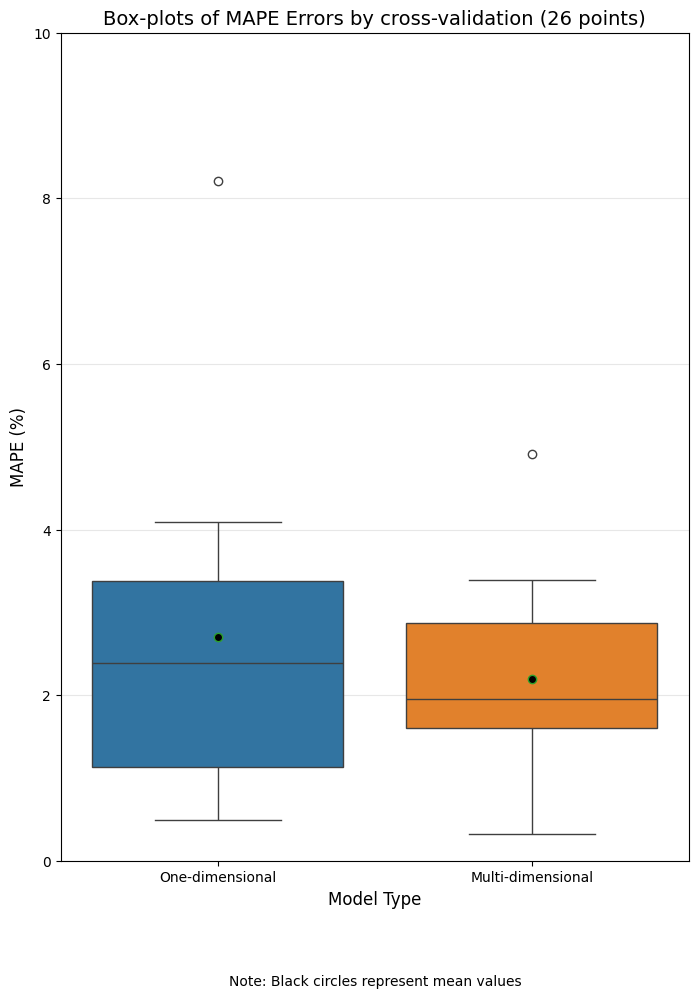

In [1169]:
# Создаем DataFrame для визуализации
data = pd.DataFrame({
    'One-dimensional': np.array(one_history[:]),
    'Multi-dimensional': np.array(multi_history['var_0']),
})

# Преобразуем данные в длинный формат
data_melted = data.melt(var_name='Model', value_name='MAPE')

# Настраиваем размер графика
plt.figure(figsize=(7, 10))

# Рисуем boxplot
sns.boxplot(
    x='Model', 
    y='MAPE', 
    data=data_melted,
    hue='Model',
    legend=False,
    showmeans=True,  # Показываем средние значения
    meanprops={'marker':'o', 'markerfacecolor':'black'}
)

# Добавляем заголовок и подписи
plt.title("Box-plots of MAPE Errors by cross-validation (26 points)", fontsize=14)
plt.xlabel("Model Type", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.grid(True, axis='y', alpha=0.3)

# Добавляем аннотации
plt.text(
    x=0.5, y=-0.15, 
    s='Note: Black circles represent mean values',
    fontsize=10, ha='center', transform=plt.gca().transAxes
)

plt.tight_layout()
plt.ylim(0,10)

Text(0.5, 1.0, 'MAPE by expanding cross-validation')

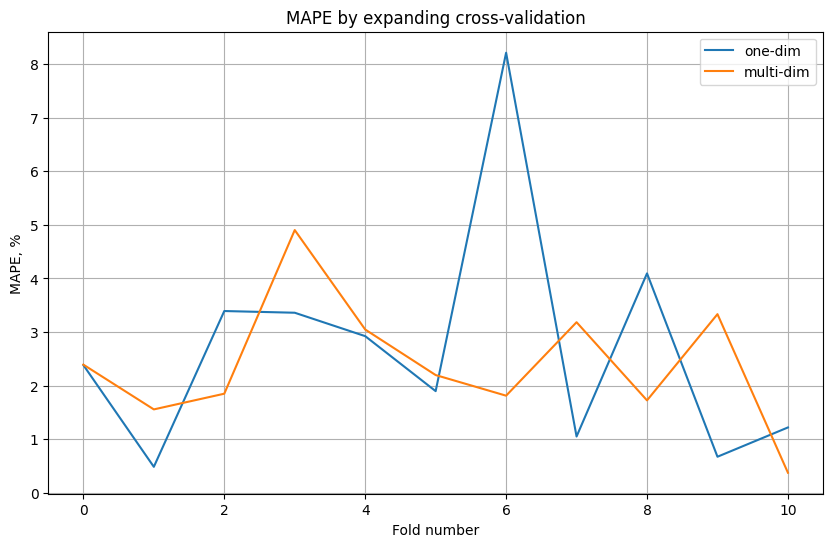

In [1066]:
plt.figure(figsize=(10,6))
plt.plot(one_history, label='one-dim')
plt.plot(multi_history['var_0'], label='multi-dim')
plt.legend()
plt.grid()
plt.xlabel('Fold number')
plt.ylabel('MAPE, %')
plt.title('MAPE by expanding cross-validation')

## Rolling

(0.0, 10.0)

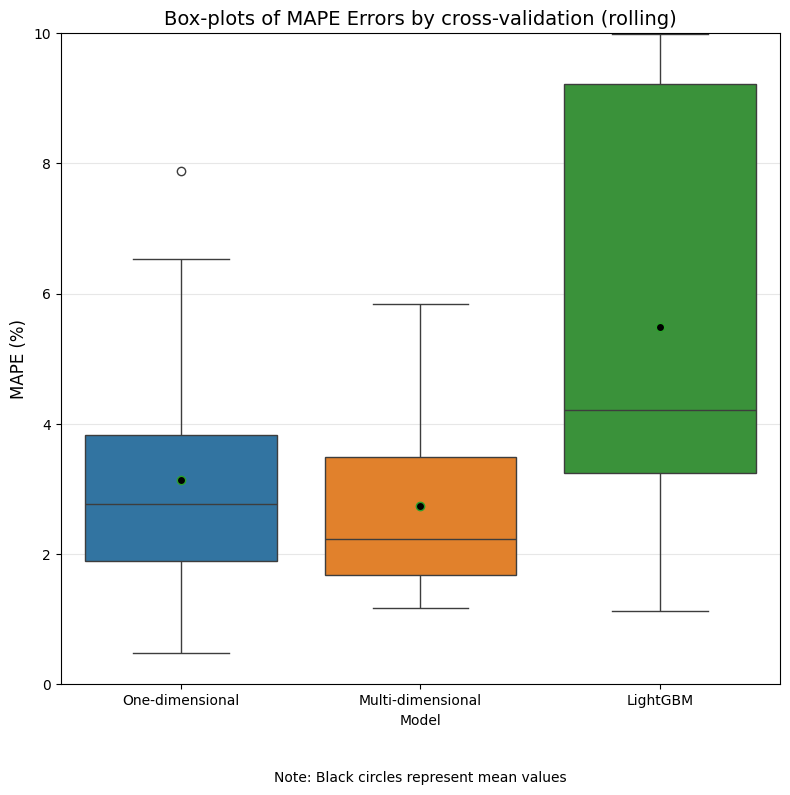

In [ ]:
# Создаем DataFrame для визуализации
data = pd.DataFrame({
    'One-dimensional': np.array(one_history_sch2),
    'Multi-dimensional': np.array(multi_history_sch2['var_0']),
    # 'LightGBM': np.array(history_mape_lg)
})

# Преобразуем данные в длинный формат
data_melted = data.melt(var_name='Model', value_name='MAPE')

# Настраиваем размер графика
plt.figure(figsize=(6, 6))

# Рисуем boxplot
sns.boxplot(
    x='Model', 
    y='MAPE', 
    data=data_melted,
    hue='Model',
    legend=False,
    showmeans=True,  # Показываем средние значения
    meanprops={'marker':'o', 'markerfacecolor':'black'}
)

# Добавляем заголовок и подписи
plt.title("Box-plots of MAPE Errors by cross-validation (rolling)", fontsize=14)
plt.xlabel("Model Type", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.grid(True, axis='y', alpha=0.3)

# Добавляем аннотации
plt.text(
    x=0.5, y=-0.15, 
    s='Note: Black circles represent mean values',
    fontsize=10, ha='center', transform=plt.gca().transAxes
)

plt.tight_layout()
plt.ylim(0,10)

In [1255]:
len(history_mape_lg)

8

(0.0, 10.0)

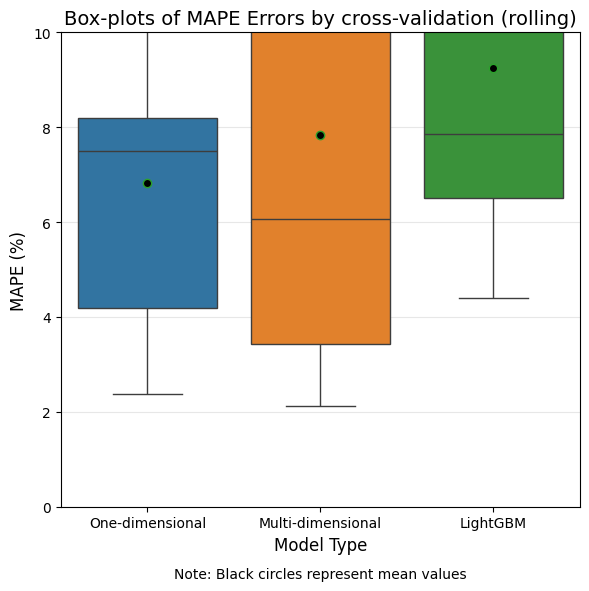

In [1284]:
# Создаем DataFrame для визуализации
data = pd.DataFrame({
    'One-dimensional': np.array(one_history_sch2),
    'Multi-dimensional': np.array(multi_history_sch2['var_0']),
    'LightGBM': np.array(history_mape_lg)
})

# Преобразуем данные в длинный формат
data_melted = data.melt(var_name='Model', value_name='MAPE')

# Настраиваем размер графика
plt.figure(figsize=(6, 6))

# Рисуем boxplot
sns.boxplot(
    x='Model', 
    y='MAPE', 
    data=data_melted,
    hue='Model',
    legend=False,
    showmeans=True,  # Показываем средние значения
    meanprops={'marker':'o', 'markerfacecolor':'black'}
)

# Добавляем заголовок и подписи
plt.title("Box-plots of MAPE Errors by cross-validation (rolling)", fontsize=14)
plt.xlabel("Model Type", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.grid(True, axis='y', alpha=0.3)

# Добавляем аннотации
plt.text(
    x=0.5, y=-0.15, 
    s='Note: Black circles represent mean values',
    fontsize=10, ha='center', transform=plt.gca().transAxes
)

plt.tight_layout()
plt.ylim(0,10)

In [1285]:
round(pd.DataFrame({
    'Model': ['ESN-FT (one-dim)', 'ESN-FT (mult-dim)', 'LightGBM'],
    'MAPE': [np.array(one_history_sch2).mean(), np.array(multi_history_sch2['var_0']).mean(),np.array(history_mape_lg).mean()],
    'MAE': [np.array(one_history_sch2_mae).mean(), np.array(multi_history_sch2_mae['var_0']).mean(),np.array(lg_mae).mean()]
    }).head(),2)

,Model,MAPE,MAE
0,ESN-FT (one-dim),6.82,17482.04
1,ESN-FT (mult-dim),7.83,20704.77
2,LightGBM,9.26,23638.85


Text(0.5, 1.0, 'MAPE by rolling cross-validation')

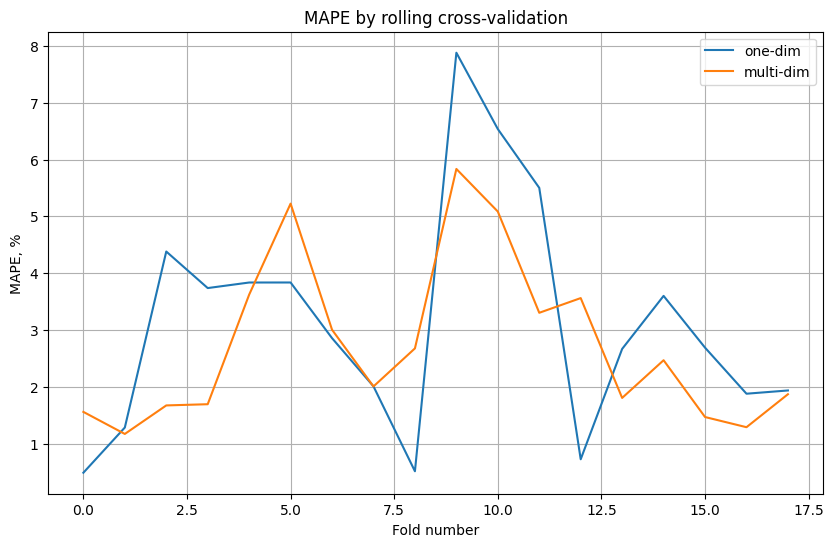

In [1068]:
plt.figure(figsize=(10,6))
plt.plot(one_history_sch2, label='one-dim')
plt.plot(multi_history_sch2['var_0'], label='multi-dim')
plt.legend()
plt.grid()
plt.xlabel('Fold number')
plt.ylabel('MAPE, %')
plt.title('MAPE by rolling cross-validation')

In [646]:
# многомерный простой vs одномерный наш 

In [1069]:
# Back to real from log

def back_to_real(loged_array, init):
    to_real = np.exp(loged_array.cumsum() + np.log(init))
    return to_real

In [1070]:
def _calc_metrics(y_true, y_pred, metric_list):
        """
        Calculate chosen metrics: MSE, MAE, MAPE
        Return a dict with each metric: value
        Round results to 2 decimals.
        """
        eps = 1e-9  # to avoid div-by-zero
        results = {}

        if len(y_true.shape) == 2 and y_true.shape[1] == 1:
            # flatten for univariate
            y_true = y_true.flatten()
            y_pred = y_pred.flatten()

        for metric in metric_list:
            if metric.upper() == 'MSE':
                mse_val = np.mean((y_true - y_pred) ** 2)
                results['MSE'] = round(mse_val, 2)
            elif metric.upper() == 'MAE':
                mae_val = np.mean(np.abs(y_true - y_pred))
                results['MAE'] = round(mae_val, 2)
            elif metric.upper() == 'MAPE':
                mape_val = np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100
                results['MAPE'] = round(mape_val, 2)
            else:
                raise ValueError(f"Unsupported metric: {metric}")
        return results

In [1071]:
#одномерный обычный
def cross_validation_esn_base(func, time_series, time_delta, metric_list, schema='schema_1', drop_step=1, train_size=78):

    if schema == 'schema_1':
        L = len(time_series)
        N = L // time_delta
        F = L % time_delta  # Остаточная часть (конец ряда)

        if N <= 1:
            raise ValueError(f"Change time_delta, not enough data for CV")
        
        history_metric = {metric: [] for metric in metric_list}
        initial_series = back_to_real(time_series, data_mredc_date['close'][0])

        for n in range(1, N+1):

            # Индексы для разделения данных
            train_end = time_delta * n
            test_start = train_end
            test_end = test_start + time_delta

            # Проверка выхода за границы данных
            if test_end > len(initial_series):
                break

            # Разделение данных
            X_train = time_series[:train_end - 1].values.reshape(-1, 1)
            y_train = time_series[1:train_end].values.reshape(-1, 1)

            y_test = initial_series[test_start:test_end].values.reshape(-1,1)

            model = func(1)
            model = model.fit(X_train, y_train)

            current = X_train[-1]
            pred_logs = []
            for i in range(time_delta):
                pred_logs.append(model.run(current))
                current = pred_logs[i]
            # print(np.array(pred_logs).flatten().reshape(-1,1).shape, time_series[:k_folds*time_delta*n].values.reshape(-1, 1).shape)
            pred_real = back_to_real(np.concatenate((time_series[:time_delta*n].values.reshape(-1, 1), np.array(pred_logs).flatten().reshape(-1,1))),
                                      data_mredc_date['close'][0])[time_delta*n:]
            # print(y_test.shape, pred_real.shape)
            metric = _calc_metrics(y_test, pred_real, metric_list)

            for key, value in metric.items():
                history_metric[key].append(value)
        
        if F > 0:
            train_end = L - F
            test_start = train_end
            test_end = L  # Используем весь остаток

            X_train = time_series[:train_end - 1].values.reshape(-1, 1)
            y_train = time_series[1:train_end].values.reshape(-1, 1)
            y_test = initial_series[test_start:test_end].values.reshape(-1, 1)

            model = func(1)
            model = model.fit(X_train, y_train)

            current = X_train[-1]
            pred_logs = []
            
            for i in range(F):  # Используем остаточную часть
                pred_logs.append(model.run(current))
                current = pred_logs[i]

            pred_real = back_to_real(np.concatenate((time_series[:train_end].values.reshape(-1, 1), 
                                                    np.array(pred_logs).flatten().reshape(-1, 1))), 
                                    data_mredc_date['close'][0])[train_end:]

            metric = _calc_metrics(y_test, pred_real, metric_list)
            for key, value in metric.items():
                history_metric[key].append(value)
        
        model = func(1)
        model.fit(time_series[:-1].values.reshape(-1, 1), time_series[1:].values.reshape(-1, 1))

        return model, history_metric

    elif schema == 'schema_2':
        
        history_metric = {metric: [] for metric in metric_list}
        initial_series = back_to_real(time_series, data_mredc_date['close'][0])
        l_ts = len(time_series)

        for i in range(0, l_ts-train_size-time_delta, drop_step):
            fold = time_series[i:i+train_size+time_delta]
            log_fold = np.log(fold).diff().dropna().values.reshape(-1, 1)

            X_train = log_fold[:train_size-1]
            y_train = log_fold[1:train_size]

            y_test = fold[train_size:].values.reshape(-1,1)

            model = func(1)
            model = model.fit(X_train, y_train)

            current = X_train[-1]
            pred_logs = []

            for j in range(time_delta):
                pred_logs.append(model.run(current))
                current = pred_logs[j]
            pred_real = back_to_real(np.concatenate((log_fold[:train_size], np.array(pred_logs).flatten().reshape(-1,1))), fold.values.reshape(-1,1)[0])[train_size:]
            # print(y_test.shape, pred_real.shape)
            metric = _calc_metrics(y_test, pred_real, metric_list)


            for key, value in metric.items():
                history_metric[key].append(value)

        fold = time_series[i+drop_step:i+drop_step+train_size+time_delta]
        log_fold = np.log(fold).diff().dropna().values.reshape(-1, 1)

        model = func(1)
        model.fit(log_fold[:train_size-1], log_fold[1:train_size])
        
        return model, history_metric
    

In [1072]:
def cross_validation_multi_esn_base(func, input_dim, time_series, time_delta, metric_list, schema='schema_1', drop_step=1, train_size=78):
    '''
    func: it's a model class, in particular Reservoir class;
    input_dim: input dimension. It could be more than 1, but it's important that target value at the last index;
    time_series: time series for train and prediction. For "schema_1" it should be log_return time series, for "schema_2" time series should
    contain moving average target feature at the last index;
    time_delta: time range for prediction and validation;
    metric_list: list of estimating metrics, it can be MAPE, MAE and MSE;
    schema: type of cross-validation, in the first option (schema_1) on each step training size is increased by time_delta. Choosing second option
    (schema_2) cross-validation you should define 'drop_step' and 'train_size', in this type on each 'drop_step' training set will be moved, so
    only 'training_size' window will be used for training;
    drop_step: number of point to drop, using in 'schema_2' cross-validation;
    train_size: size of time series to use in train in 'schema_2' cross-validation;
    '''

    if schema == 'schema_1':
        L = len(time_series)
        N = L // time_delta  # Количество полных fold'ов
        F = L % time_delta  # Остаточная часть (конец ряда)

        if N < 1:
            raise ValueError(f"Change time_delta, not enough data for CV")

        history_metric = {metric: [] for metric in metric_list}
        history_metric['preds'] = []
        initial_series = back_to_real(data_mredc_date['log_return_close'].dropna(), data_mredc_date['close'][0])

        for n in range(1, N+1):

            # Индексы для разделения данных
            train_end = time_delta * n
            test_start = train_end
            test_end = test_start + time_delta

            # Проверка выхода за границы данных
            if test_end > len(initial_series):
                break

            # Разделение данных
            X_train = time_series[:train_end - 1]
            y_train = time_series[1:train_end]
            y_test = initial_series[test_start:test_end]

            # Обучение модели
            model = func(input_dim)
            model = model.fit(X_train, y_train)

            current = X_train[-1]
            pred_logs = []
            
            for i in range(time_delta):
                pred_logs.append(model.run(current).reshape(input_dim)[-1])
                current = model.run(current).reshape(input_dim)

            pred_real = back_to_real(np.concatenate((time_series[:train_end][:,-1].reshape(-1, 1), 
                                                    np.array(pred_logs).flatten().reshape(-1, 1))), 
                                    data_mredc_date['close'][0])[train_end:]

            metric = _calc_metrics(y_test, pred_real, metric_list)
            history_metric['preds'].append(pred_real)
            for key, value in metric.items():
                history_metric[key].append(value)

        # **Добавляем последний fold с остатком данных (если есть остаток)**
        if F > 0:
            train_end = L - F
            test_start = train_end
            test_end = L  # Используем весь остаток

            X_train = time_series[:train_end - 1]
            y_train = time_series[1:train_end]
            y_test = initial_series[test_start:test_end]

            model = func(input_dim)
            model = model.fit(X_train, y_train)

            current = X_train[-1]
            pred_logs = []
            
            for i in range(F):  # Используем остаточную часть
                pred_logs.append(model.run(current).reshape(input_dim)[-1])
                current = model.run(current).reshape(input_dim)

            pred_real = back_to_real(np.concatenate((time_series[:train_end][:,-1].reshape(-1, 1), 
                                                    np.array(pred_logs).flatten().reshape(-1, 1))), 
                                    data_mredc_date['close'][0])[train_end:]

            metric = _calc_metrics(y_test, pred_real, metric_list)
            history_metric['preds'].append(pred_real)

            for key, value in metric.items():
                history_metric[key].append(value)

        # **Обучаем модель на всем временном ряде (для финального использования)**
        model = func(input_dim)
        model.fit(time_series[:-1], time_series[1:])
        
        return model, history_metric
    
    elif schema == 'schema_2':
        history_metric = {metric: [] for metric in metric_list}        
        
        initial_series = back_to_real(time_series, data_mredc_date['close'][0])
        l_ts = len(time_series)

        for i in range(0, l_ts-train_size-time_delta, drop_step):
            
            fold = time_series[i:i+train_size+time_delta]

            y_test = fold.iloc[train_size:, -1].values
            fold['log_close'] = np.log(fold['MA_close']).diff()
            ma_0 = fold['MA_close'].iloc[0]
            fold.drop(columns=['MA_close'], inplace=True)

            log_fold = fold.dropna().values

            X_train = log_fold[:train_size-1]
            y_train = log_fold[1:train_size]

            model = func(input_dim)
            model = model.fit(X_train, y_train)

            current = X_train[-1]
            pred_logs = []

            for j in range(time_delta):
                pred_logs.append(model.run(current).reshape(input_dim)[-1])
                current =  model.run(current).reshape(input_dim)
                
            pred_real = back_to_real(np.concatenate((log_fold[:train_size][:,-1].reshape(-1, 1), np.array(pred_logs).flatten().reshape(-1,1))), ma_0)[train_size:]
            # print(y_test.shape, pred_real.shape)
            metric = _calc_metrics(y_test, pred_real, metric_list)

            for key, value in metric.items():
                history_metric[key].append(value)
        
        fold = time_series[i+drop_step:i+drop_step+train_size+time_delta]
        fold['MA_close'], log_fold = np.log(fold['MA_close']).diff(), fold.dropna().values

        model = func(input_dim)
        model = model.fit(log_fold[:train_size-1], log_fold[1:train_size])

        return model, history_metric


In [1184]:
_, history_one_esn = cross_validation_esn_base(reset_esn, dmd['log_return_close'].dropna(), 52, ['MAPE', 'MAE'], train_size=104)

In [ ]:
_, history_one_esn_sc2 = cross_validation_esn_base(reset_esn, data_mredc_date.dropna()['MA_close'], 26, ['MAPE', 'MAE'],
                                                    schema='schema_2', drop_step=13, train_size=104)

MULTI

In [1185]:
_, history_multi_esn = cross_validation_multi_esn_base(reset_esn, 4,
                                                        dmd[['curs', 'curs_MA',
                                                             'infl','log_return_close']].dropna().values,
                                                          52, ['MAPE', 'MAE'], train_size=104)

In [ ]:
_, history_multi_esn_sch2 = cross_validation_multi_esn_base(reset_esn, 7,
                                                            dmd[['curs', 'curs_laged', 'curs_MA',
                                                             'infl', 'curs_MA_laged',
                                                             'infl_laged', 'MA_close']].dropna(),
                                                               26, ['MAPE', 'MAE'], schema='schema_2', drop_step=13, train_size=104)

(0.0, 5.0)

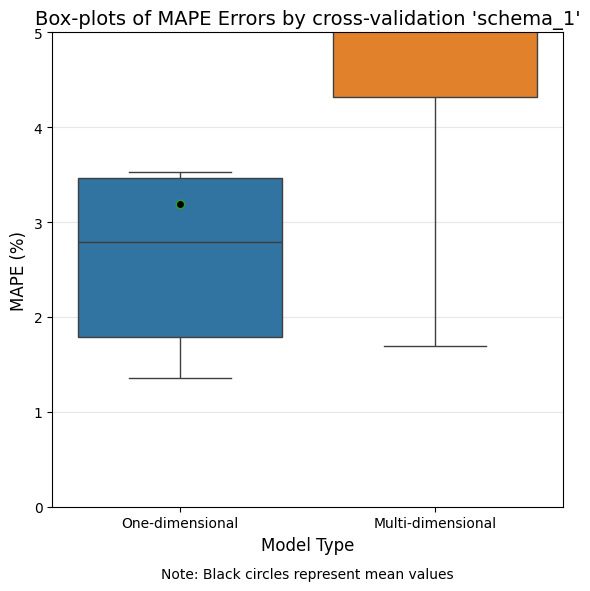

In [1155]:
# Создаем DataFrame для визуализации
data = pd.DataFrame({
    'One-dimensional': np.array(history_one_esn['MAPE']),
    'Multi-dimensional': np.array(history_multi_esn['MAPE']),
})

# Преобразуем данные в длинный формат
data_melted = data.melt(var_name='Model', value_name='MAPE')

# Настраиваем размер графика
plt.figure(figsize=(6, 6))

# Рисуем boxplot
sns.boxplot(
    x='Model', 
    y='MAPE', 
    data=data_melted,
    hue='Model',
    legend=False,
    showmeans=True,  # Показываем средние значения
    meanprops={'marker':'o', 'markerfacecolor':'black'}
)

# Добавляем заголовок и подписи
plt.title("Box-plots of MAPE Errors by cross-validation 'schema_1'", fontsize=14)
plt.xlabel("Model Type", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.grid(True, axis='y', alpha=0.3)

# Добавляем аннотации
plt.text(
    x=0.5, y=-0.15, 
    s='Note: Black circles represent mean values',
    fontsize=10, ha='center', transform=plt.gca().transAxes
)

plt.tight_layout()
plt.ylim(0,5)

In [1081]:
len(history_multi_esn_sch2['MAPE'])

20

In [1083]:
len(history_one_esn_sc2['MAPE'])

22

(0.0, 5.0)

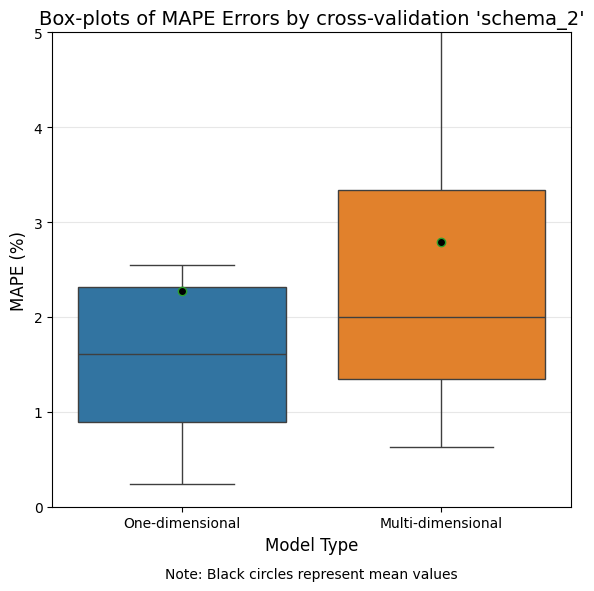

In [1085]:
# Создаем DataFrame для визуализации
data = pd.DataFrame({
    'One-dimensional': np.array(history_one_esn_sc2['MAPE'][2:]),
    'Multi-dimensional': np.array(history_multi_esn_sch2['MAPE']),
})

# Преобразуем данные в длинный формат
data_melted = data.melt(var_name='Model', value_name='MAPE')

# Настраиваем размер графика
plt.figure(figsize=(6, 6))

# Рисуем boxplot
sns.boxplot(
    x='Model', 
    y='MAPE', 
    data=data_melted,
    hue='Model',
    legend=False,
    showmeans=True,  # Показываем средние значения
    meanprops={'marker':'o', 'markerfacecolor':'black'}
)

# Добавляем заголовок и подписи
plt.title("Box-plots of MAPE Errors by cross-validation 'schema_2'", fontsize=14)
plt.xlabel("Model Type", fontsize=12)
plt.ylabel("MAPE (%)", fontsize=12)
plt.grid(True, axis='y', alpha=0.3)

# Добавляем аннотации
plt.text(
    x=0.5, y=-0.15, 
    s='Note: Black circles represent mean values',
    fontsize=10, ha='center', transform=plt.gca().transAxes
)

plt.tight_layout()
plt.ylim(0,5)

In [1086]:
len(one_history_sch2)

18

In [1087]:
len(history_one_esn_sc2['MAPE'])

22

# Box-Plots Comparison

ROLLING

In [1187]:
len(one_history_sch2)

18

In [1188]:
len(history_one_esn_sc2['MAPE'])

22

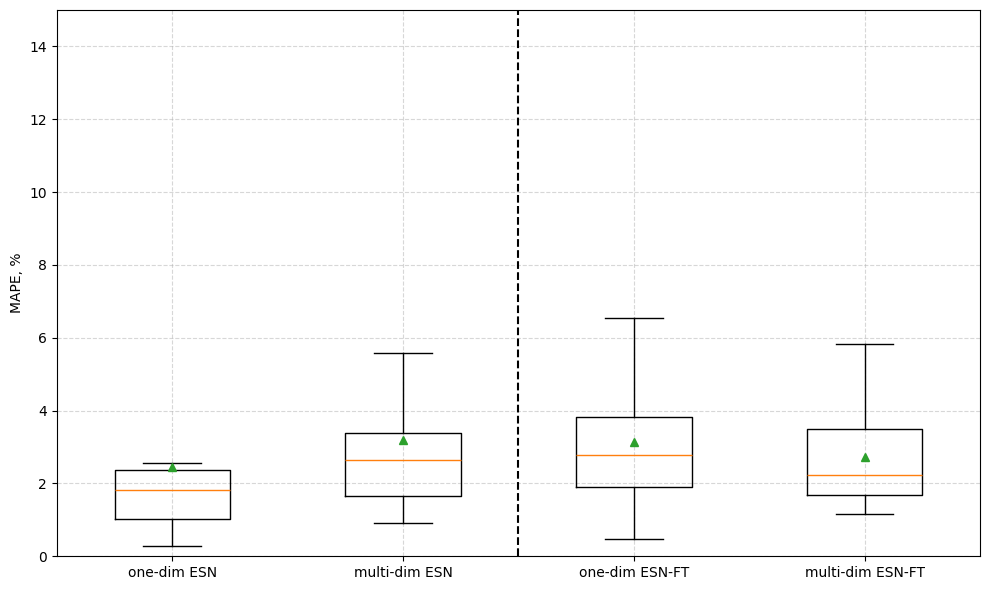

In [1189]:
import matplotlib.pyplot as plt
import numpy as np

# Собираем данные вместе
data = [history_one_esn_sc2['MAPE'][4:], history_multi_esn_sch2['MAPE'][4:], one_history_sch2, multi_history_sch2['var_0']]

# Создаем график
fig, ax = plt.subplots(figsize=(10, 6))

# Рисуем ящики с усами
ax.boxplot(data, widths=0.5, showfliers=False, showmeans=True)

# Добавляем вертикальную линию, отделяющую первые два ящика от последних двух
ax.axvline(x=2.5, color='black', linestyle='--')

# Подписи по оси X
ax.set_xticklabels(['one-dim ESN', 'multi-dim ESN', 'one-dim ESN-FT', 'multi-dim ESN-FT'])

# Подпись оси Y
ax.set_ylabel('MAPE, %')

# Заголовок (по желанию)
# ax.set_title('Сравнение моделей ESN и ESN-FT')

# Включаем сетку для удобства
ax.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0,15)
# Показать график
plt.tight_layout()
plt.show()

52 точки прогноза и 26 drop_step

EXPANDING

In [1190]:
len(history_one_esn['MAPE'])

7

In [1193]:
len(multi_history['var_0'])

6

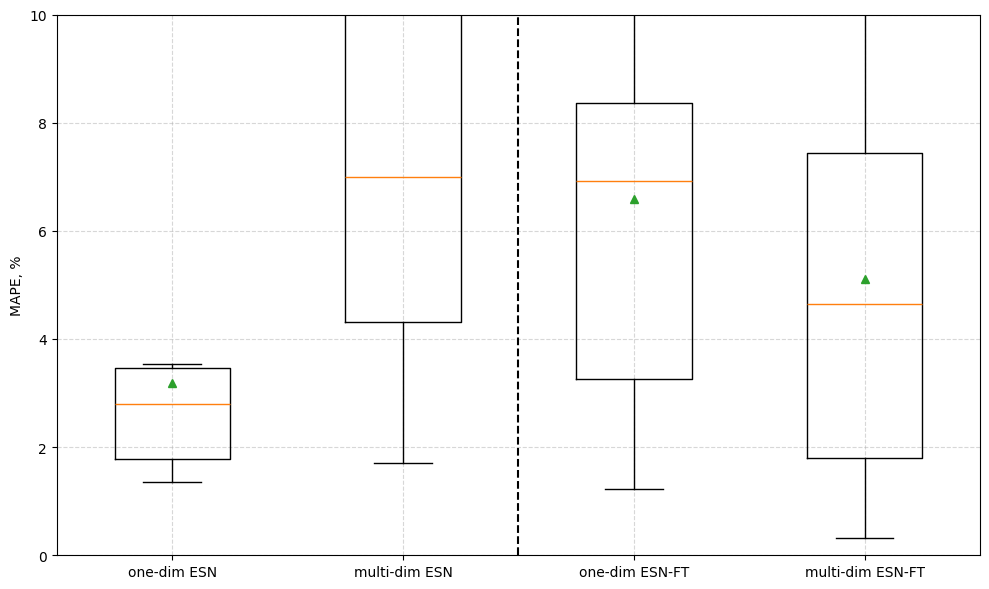

In [1194]:
# Собираем данные вместе
data = [history_one_esn['MAPE'][:], history_multi_esn['MAPE'][:], one_history, multi_history['var_0']]

# Создаем график
fig, ax = plt.subplots(figsize=(10, 6))

# Рисуем ящики с усами
ax.boxplot(data, widths=0.5, showfliers=False, showmeans=True)

# Добавляем вертикальную линию, отделяющую первые два ящика от последних двух
ax.axvline(x=2.5, color='black', linestyle='--')

# Подписи по оси X
ax.set_xticklabels(['one-dim ESN', 'multi-dim ESN', 'one-dim ESN-FT', 'multi-dim ESN-FT'])

# Подпись оси Y
ax.set_ylabel('MAPE, %')

# Заголовок (по желанию)
# ax.set_title('Сравнение моделей ESN и ESN-FT')

# Включаем сетку для удобства
ax.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0,10)
# Показать график
plt.tight_layout()
plt.show()

# LIGHTGBM

In [ ]:
# def cross_validation_lg(
#     model_factory,
#     time_series,
#     time_delta,
#     cv_type="expanding",
#     train_size=None,
#     drop_step=None,
#     train_full=False
# ):
#     """
#     Perform multi‐step MAPE CV on a 1D series with either expanding or rolling windows,
#     working directly on the provided real‐scale time_series.

#     Parameters
#     ----------
#     model_factory : callable
#         Constructor for your model (e.g. EnhancedESN_FAN), must accept input_dim=1
#         and implement .fit(X,y) and .run(u).
#     time_series : pd.Series or 1D array
#         The raw input sequence.
#     time_delta : int
#         Forecast horizon for each fold.
#     cv_type : {"expanding","rolling"}
#         "expanding": train=[0:fold*Δ], test=next Δ points.
#         "rolling" : train=[start:start+window_size], test=next Δ points.
#     window_size : int, optional
#         Required if cv_type=="rolling". Fixed length of each training window.
#     train_full : bool
#         If True, refit on the entire series at the end and return that model.

#     Returns
#     -------
#     final_model : object or None
#         The model refit on the full series if train_full else None.
#     history_mape : List[float]
#         One MAPE per fold.
#     """
#     ts = np.asarray(time_series)
#     L = len(time_series)

#     if cv_type not in ("expanding", "rolling"):
#         raise ValueError("cv_type must be 'expanding' or 'rolling'")

#     if cv_type == "rolling" and drop_step is None:
#         raise ValueError("Must specify window_size for rolling CV")
    
#     history_mape = []
#     history_mae = []

#     if cv_type == "expanding":
#         n_folds = (L-train_size) // time_delta
#         F = (L-train_size) % time_delta  # Остаточная часть (конец ряда)
#         for fold in range(0, n_folds+1):
#             train_end = train_size + fold * time_delta
#             test_start = train_end
#             test_end   = train_end + time_delta
#             if test_end > L:
#                 break

#             # Build train and test slices
#             X_tr = ts[:train_end-1].reshape(-1, 1)
#             y_tr = ts[1:train_end].reshape(-1, 1)
#             y_true = ts[test_start:test_end].reshape(-1, 1)

#             # Fit model
#             model = model_factory
#             model.fit(X_tr, y_tr)

#             # Generative Δ-step forecast
#             cur = y_tr[-1]
#             preds = []
#             for j in range(time_delta):
#                 cur = model.predict(cur.reshape(1, -1)).reshape(-1, 1)[0]
#                 preds.append(cur)
                    
#             # Compute MAPE
#             mape = mean_absolute_percentage_error(y_true, preds) * 100
#             history_mape.append(mape)

#             # Compute MAE
#             mae = mean_absolute_error(y_true, preds)
#             history_mae.append(mae)

#         if F > 0:
#             train_end = L - F
#             test_start = train_end
#             test_end = L  # Используем весь остаток

#             X_tr = ts[:train_end - 1].reshape(-1, 1)
#             y_tr = ts[1:train_end].reshape(-1, 1)
#             y_true = ts[test_start:test_end].reshape(-1, 1)

#             # Fit model
#             model = model_factory
#             model.fit(X_tr, y_tr)

#             # Generative Δ-step forecast
#             cur = y_tr[-1]
#             preds = []
#             for j in range(F):
#                 cur = model.predict(cur.reshape(1, -1)).reshape(-1, 1)[0]
#                 preds.append(cur)

#             # Compute MAPE
#             mape = mean_absolute_percentage_error(y_true, preds) * 100
#             history_mape.append(mape)

#             # Compute MAE
#             mae = mean_absolute_error(y_true, preds)
#             history_mae.append(mae)

#     else:  # rolling
#         for start in range(0, L-train_size-time_delta+1, drop_step):
#             train_start = start
#             train_end   = start+train_size+time_delta
#             test_start  = train_end
#             test_end    = test_start + time_delta
#             if test_end > L:
#                 break

#             X_tr = ts[train_start:train_end-1].reshape(-1, 1)
#             y_tr = ts[train_start+1:train_end].reshape(-1, 1)
#             y_true = ts[test_start:test_end].reshape(-1, 1)

#             model = model_factory
#             model.fit(X_tr, y_tr)

#             # Generative Δ-step forecast
#             cur = y_tr[-1]
#             preds = []
#             for j in range(time_delta):
#                 cur = model.predict(cur.reshape(1, -1)).reshape(-1, 1)[0]
#                 preds.append(cur)
                
#             # Compute MAPE
#             mape = mean_absolute_percentage_error(y_true, preds) * 100
#             history_mape.append(mape)

#             # Compute MAE
#             mae = mean_absolute_error(y_true, preds)
#             history_mae.append(mae)

#     final_model = None
#     if train_full:
#         X_all = ts[:-1].reshape(-1,1)
#         y_all = ts[1: ].reshape(-1,1)
#         final_model = model_factory.fit(X_all, y_all)

#     return final_model, history_mape, history_mae

In [1257]:
from lightgbm import LGBMRegressor

lg = LGBMRegressor(random_state=23, verbosity=-1)

_, history_mape_lg, lg_mae = cross_validation_lg(lg, dmd.dropna()['MA_close'], cv_type='rolling', drop_step=26, time_delta=52, train_size=104)


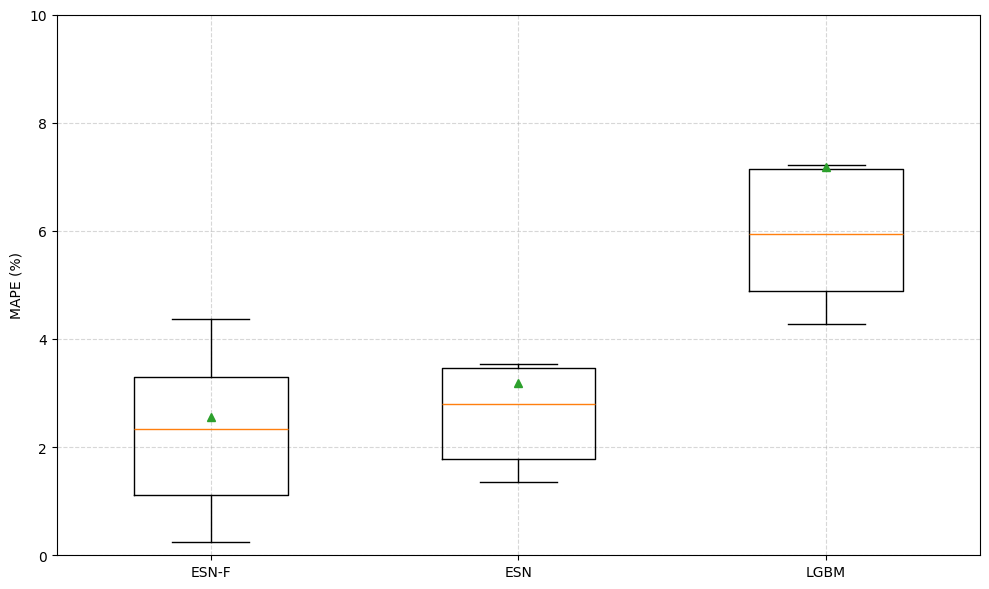

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Собираем данные вместе
# data = [multi_history['var_0'], history_one_esn['MAPE'], history_mape_lg]

# # Создаем график
# fig, ax = plt.subplots(figsize=(10, 6))

# # Рисуем ящики с усами
# ax.boxplot(data, widths=0.5, showfliers=False, showmeans=True)

# # Подписи по оси X
# ax.set_xticklabels(['ESN-F', 'ESN', 'LGBM'])

# # Подпись оси Y
# ax.set_ylabel('MAPE (%)')

# # Заголовок (по желанию)
# # ax.set_title('Сравнение моделей ESN и ESN-FT')

# # Включаем сетку для удобства
# ax.grid(True, linestyle='--', alpha=0.5)
# plt.ylim(0,10)
# # Показать график
# plt.tight_layout()
# # plt.savefig('fig3.jpg',transparent=None, dpi=600)
# plt.show()

In [ ]:
# from chaos_indic import HurstTraj, NoiseFactor, DimEmb, max_lyapunov, fourier_harmonic_count, ks_entropy_partition

# print(
#     round(HurstTraj(data_mredc_date['MA_close'].dropna())[2],2), '\n',
#     round(NoiseFactor(data_mredc_date['MA_close'].dropna()),2), '\n',
#     round(DimEmb(data_mredc_date['MA_close'].dropna())[1],2), '\n',
#     round(max_lyapunov(data_mredc_date['MA_close'].dropna().values),2), '\n',
#     round(ks_entropy_partition(data_mredc_date['MA_close'].dropna()),2), '\n',
#     fourier_harmonic_count(data_mredc_date['MA_close'].dropna())
# )

0.65 
 0.99 
 1.33 
 0.01 
 1.84 
 30
